<a href="https://colab.research.google.com/github/trancethehuman/ai-workshop-code/blob/main/Evaluate_several_software_solutions_at_once_with_Firecrawl's_crawl_and_LLM_for_judging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, install Firecrawl's Python SDK

In [ ]:
pip install firecrawl-py -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 6.1 MB/s eta 0:00:00


Then, get Firecrawl's API key and setup a client

In [ ]:
import getpass

FIRECRAWL_API_KEY = getpass.getpass("Firecrawl API Key: ")

Firecrawl API Key: ··········


In [ ]:
from firecrawl import FirecrawlApp

app = FirecrawlApp(api_key=FIRECRAWL_API_KEY)

Now setup a crawl job to gather as much information about a vendor or tool we're considering as possible. In this example, we're vetting SOC 2 SaaS tools that can help our company go through [SOC 2 compliance](https://cloud.google.com/security/compliance/soc-2?hl=en) processes (aka auditing stuff that we don't know and we are very lost)

We'll be using Drata, Secureframe and Vanta as examples.

In a real world scenario, your list could be two dozens, which may require a few days worth of research to go through. But here we can just run this one pipeline.

In [ ]:
vendors = [
    "https://secureframe.com/",
    "https://drata.com/",
    "https://www.vanta.com/"
]

In [ ]:
import time
results = []

for vendor in vendors:
  crawl_status = app.crawl_url(
      vendor,
      params={
          'limit': 3,
          'scrapeOptions': {
              'formats': ['markdown']
          }
      },
      poll_interval=30 # we're polling here, but you can pass in a webhook endpoint to receive response too.

    )

  print(crawl_status)
  results.append(crawl_status)
  time.sleep(3) # just so we can fit within firecrawl's rate limit

['[Secureframe unlocks deeper testing and automation with Custom Automated Tests\\\\\nLearn more](https://secureframe.com/blog/custom-automated-tests-announcement)\n\n![hero-bg](https://secureframe.com/_next/image?url=%2Fimages%2Fhero-bg.svg&w=3840&q=75)\n\n# Automate compliance.   Improve security. Reduce risk.\n\nBuild trust with customers using automation backed by world-class experts\n\n[Schedule a demo![angle-right](https://secureframe.com/_next/image?url=%2Fimages%2Fangle-right-green.svg&w=48&q=75)](/request-demo)![](https://secureframe-com.cdn.prismic.io/secureframe-com/ZnMGSpm069VX15Ga_Hero.svg?auto=compress%2Cformat&fit=max&w=3840)\n\n#### Trusted and used by thousands of companies\n\n![angellist](https://secureframe-com.cdn.prismic.io/secureframe-com/f1c59ad1-4b86-40c3-9606-19ac11e4d5a7_AngelList_customers_light.svg?fit=max&w=384)\n\n![lyra](https://secureframe-com.cdn.prismic.io/secureframe-com/32923a29-e911-46ae-ade6-04846aa1b0f6_lyra-logo_customers_light.svg?fit=max&w=384)
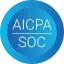
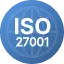
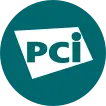
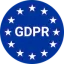
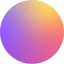
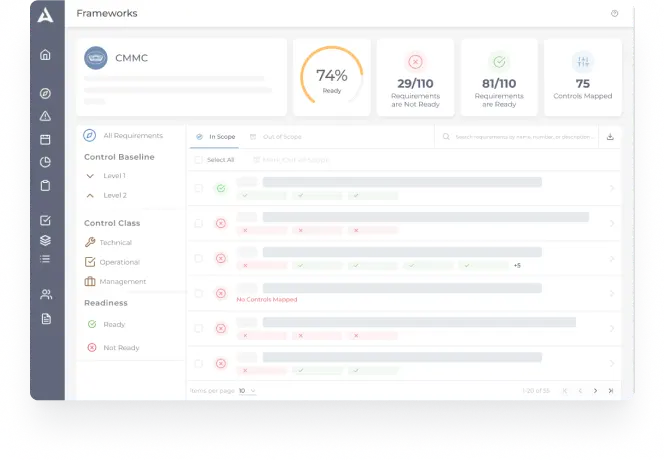
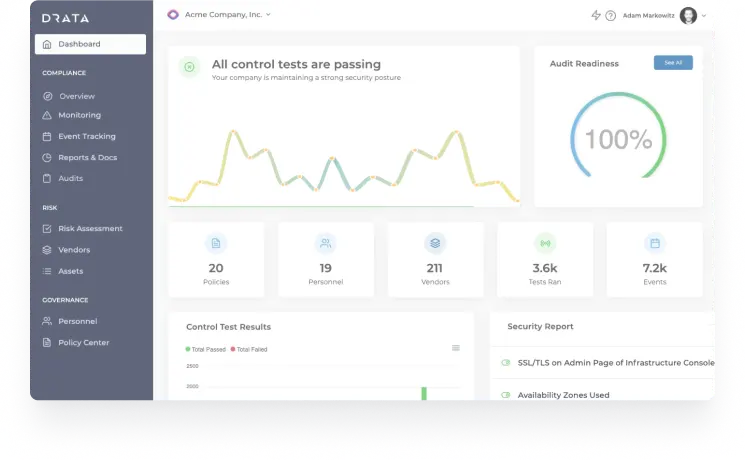
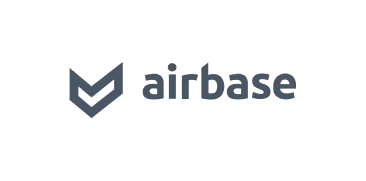
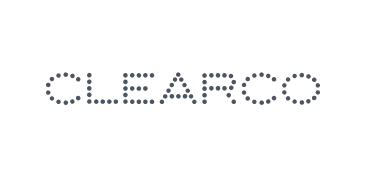
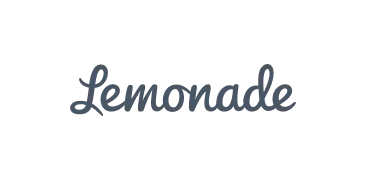
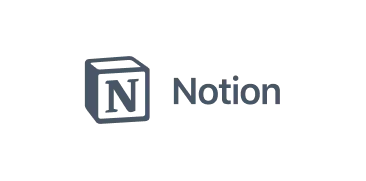
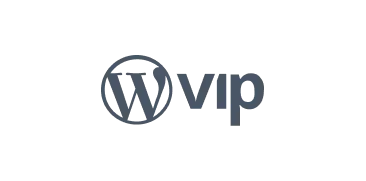
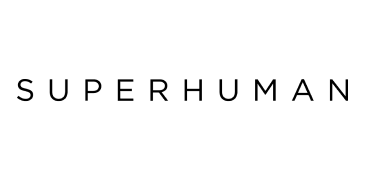
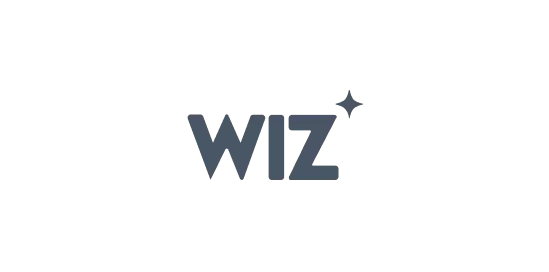
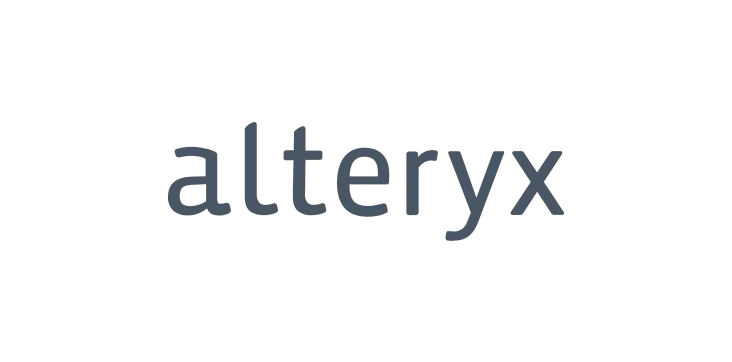
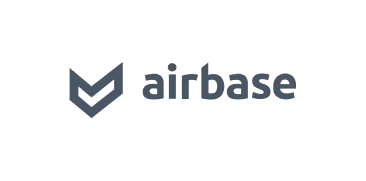
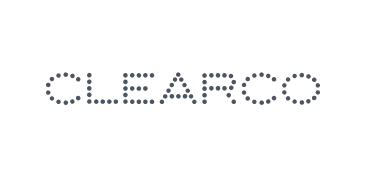
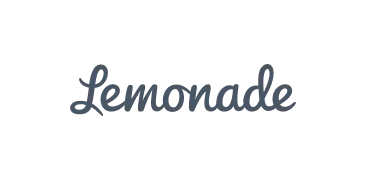
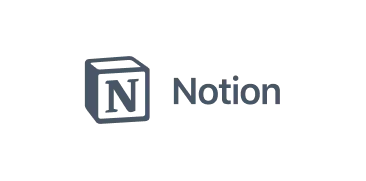
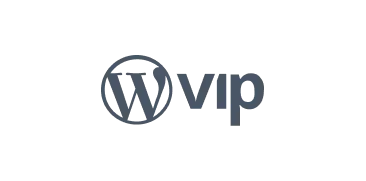
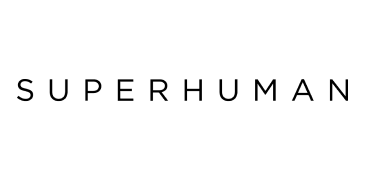
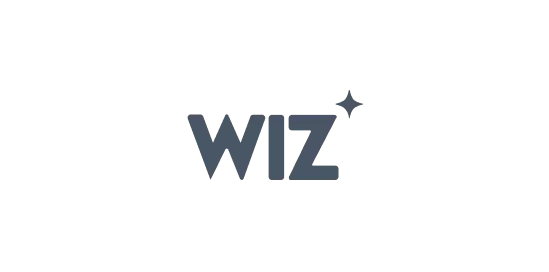
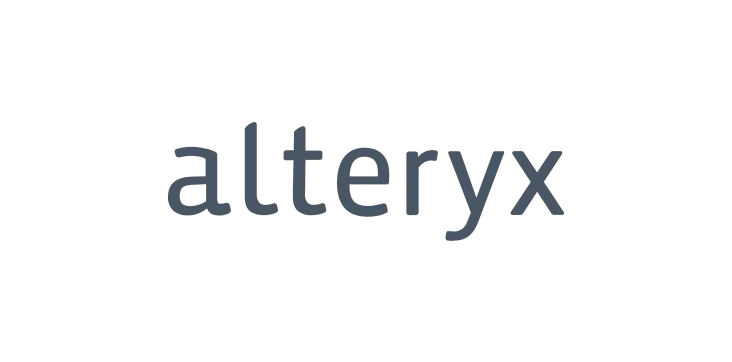
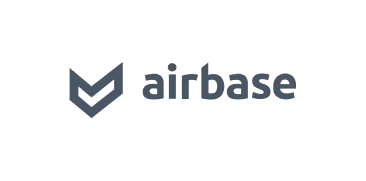
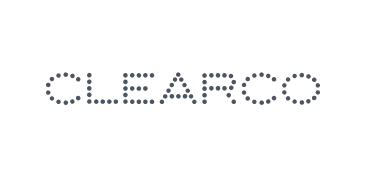
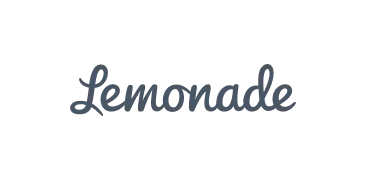
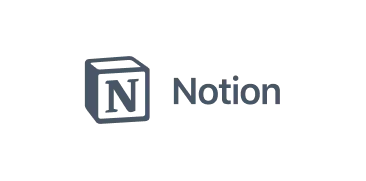
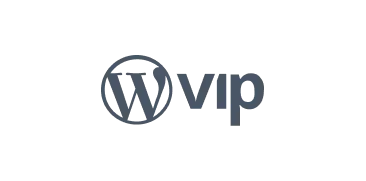
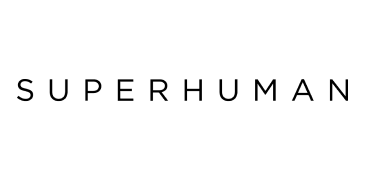
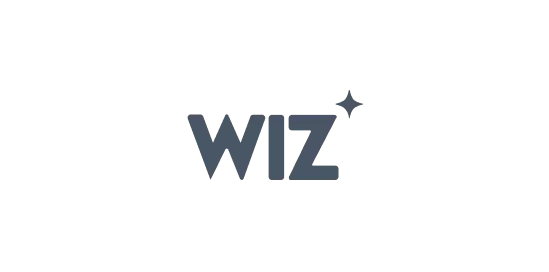
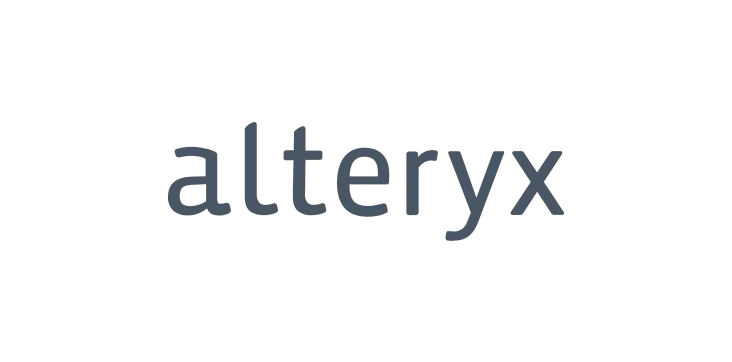
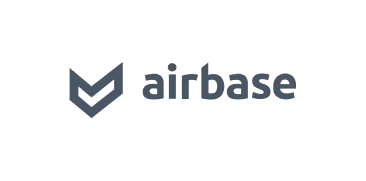
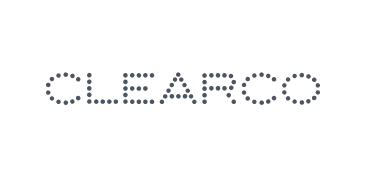
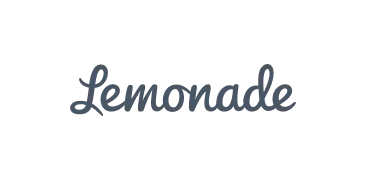
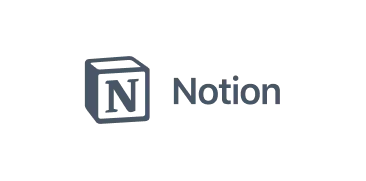
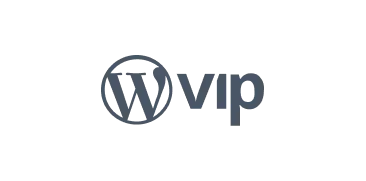
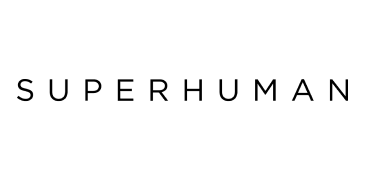
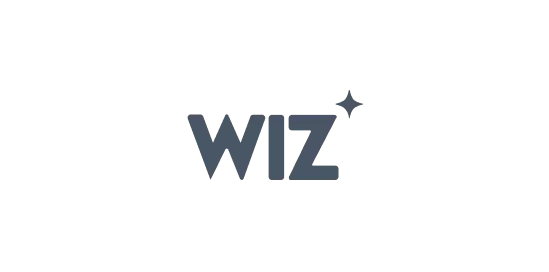
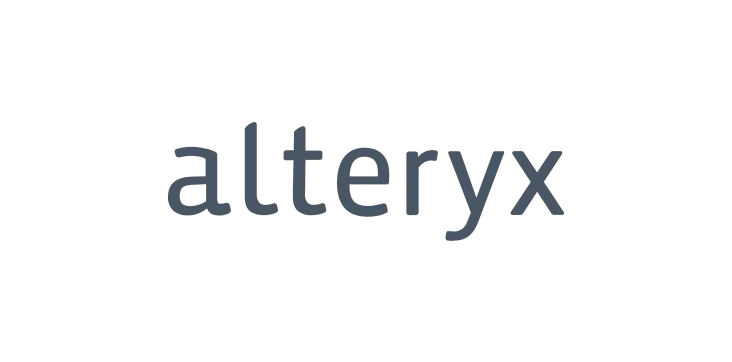
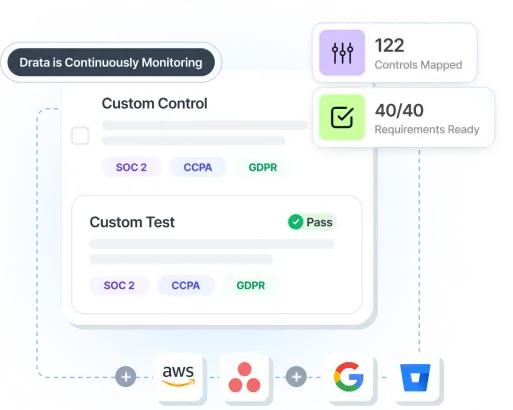
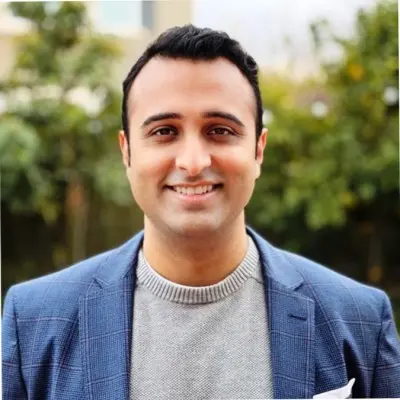
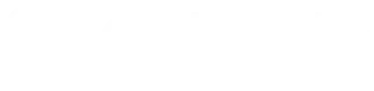
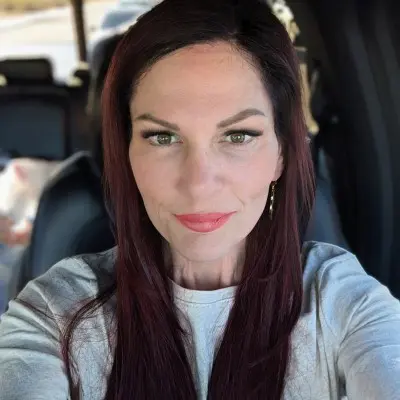
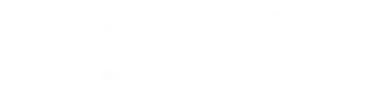
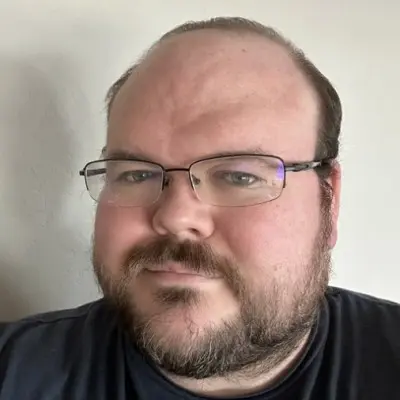
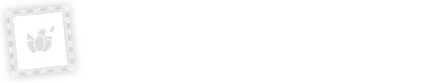
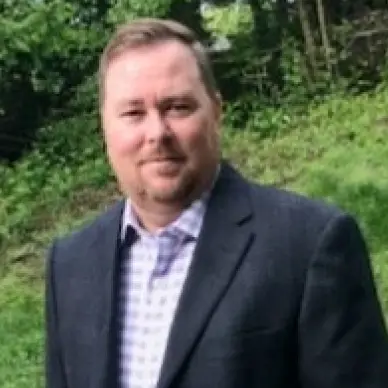
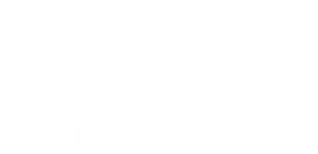
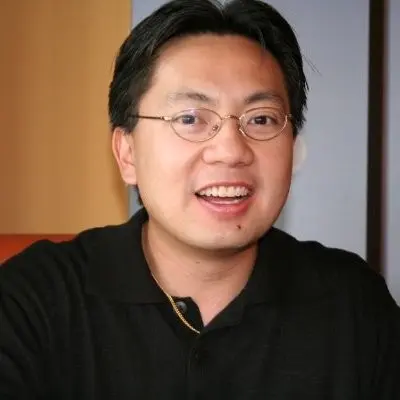
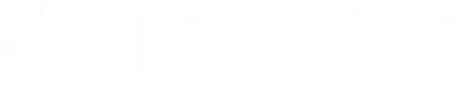
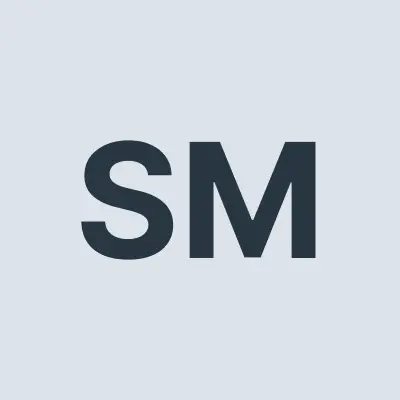
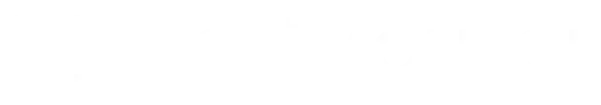
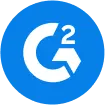
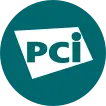
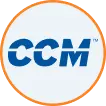
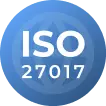
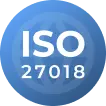
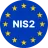
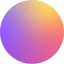
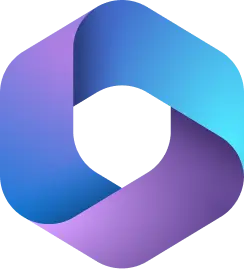
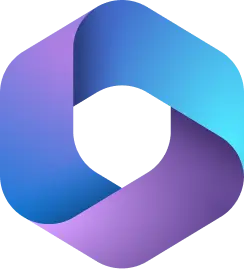
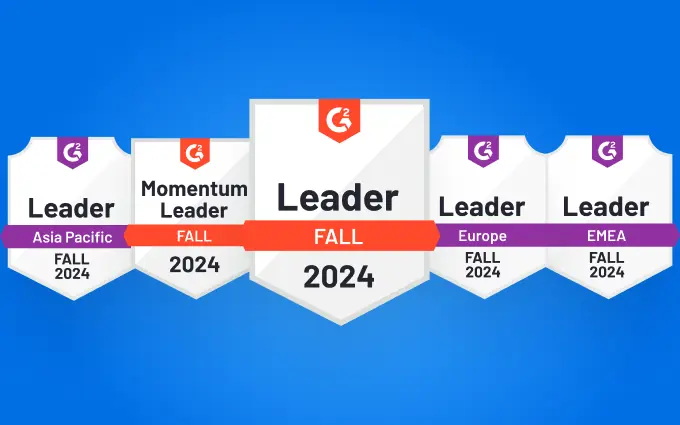
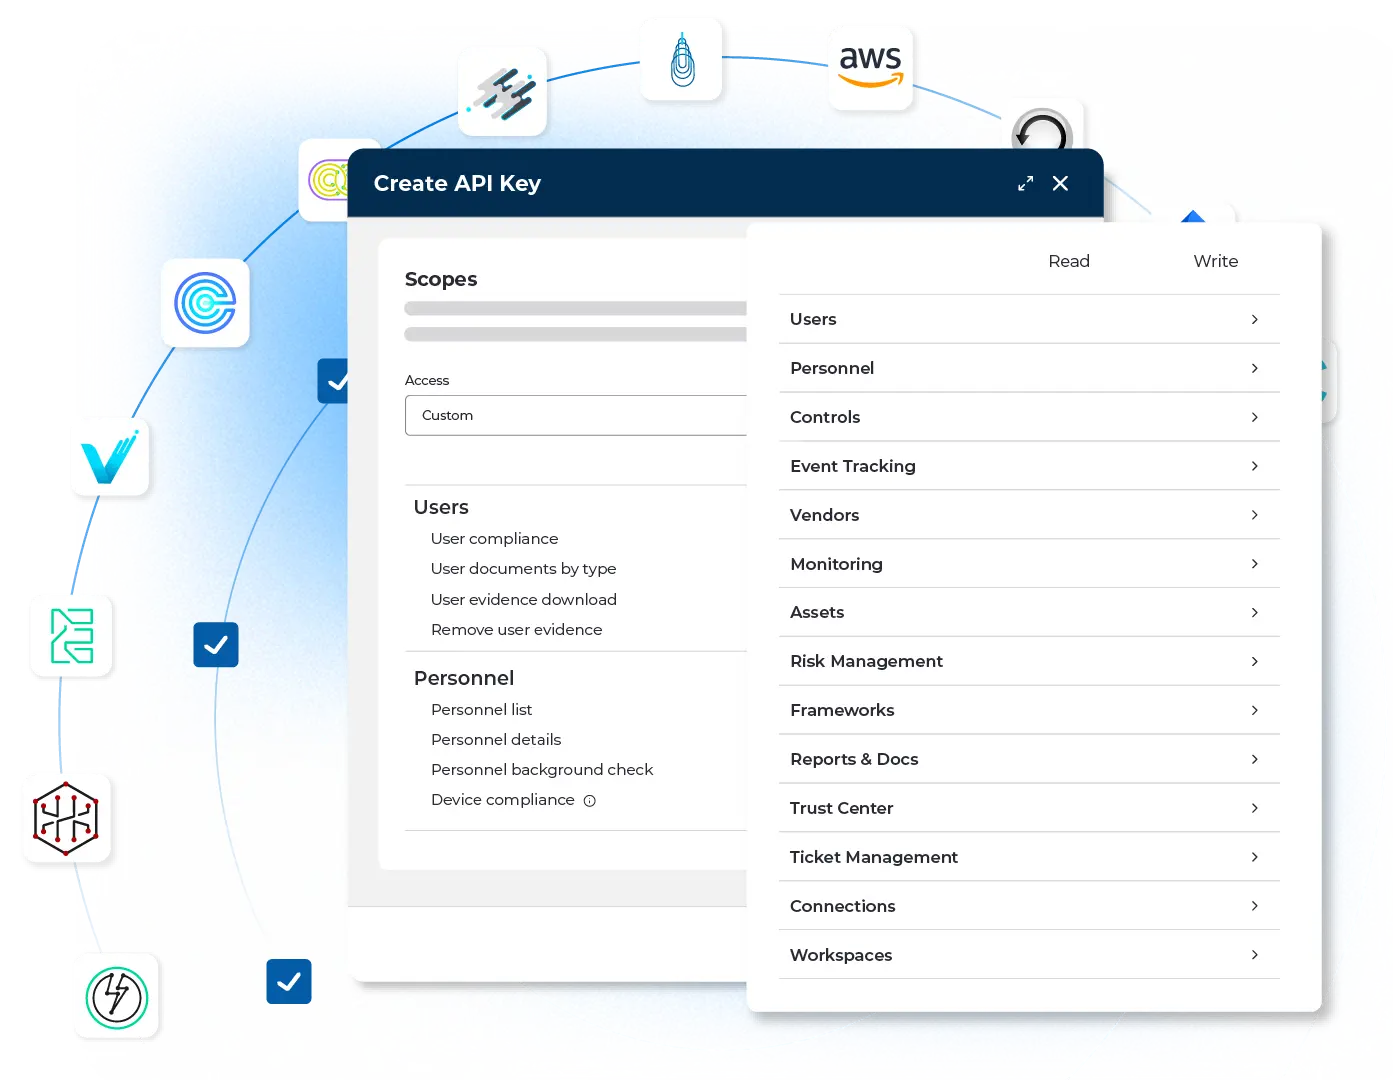
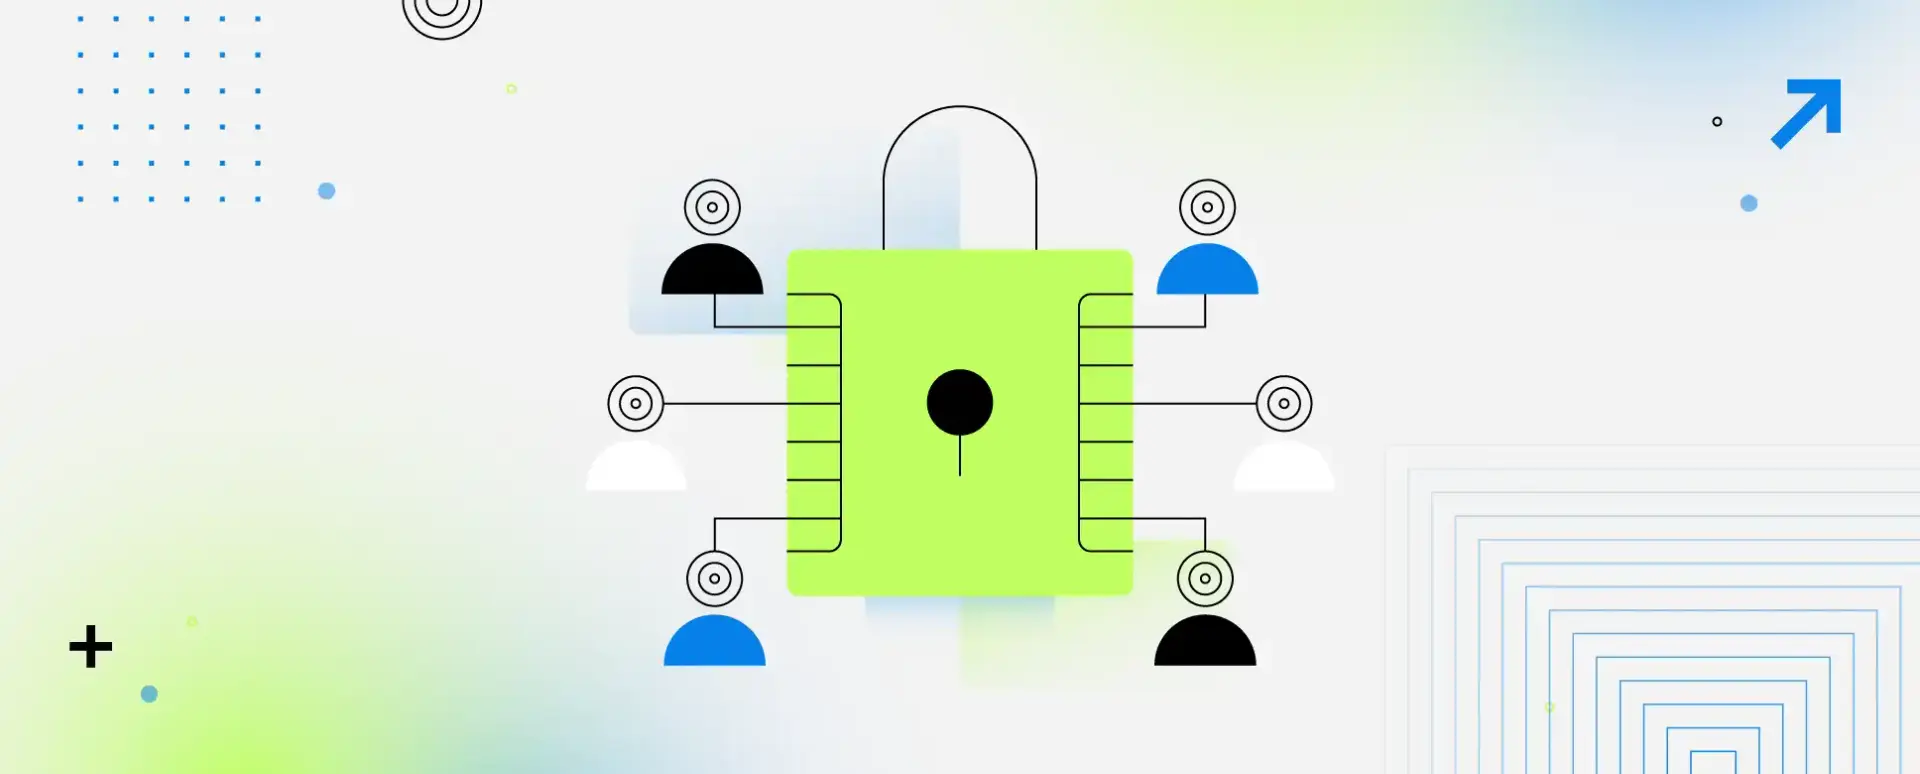
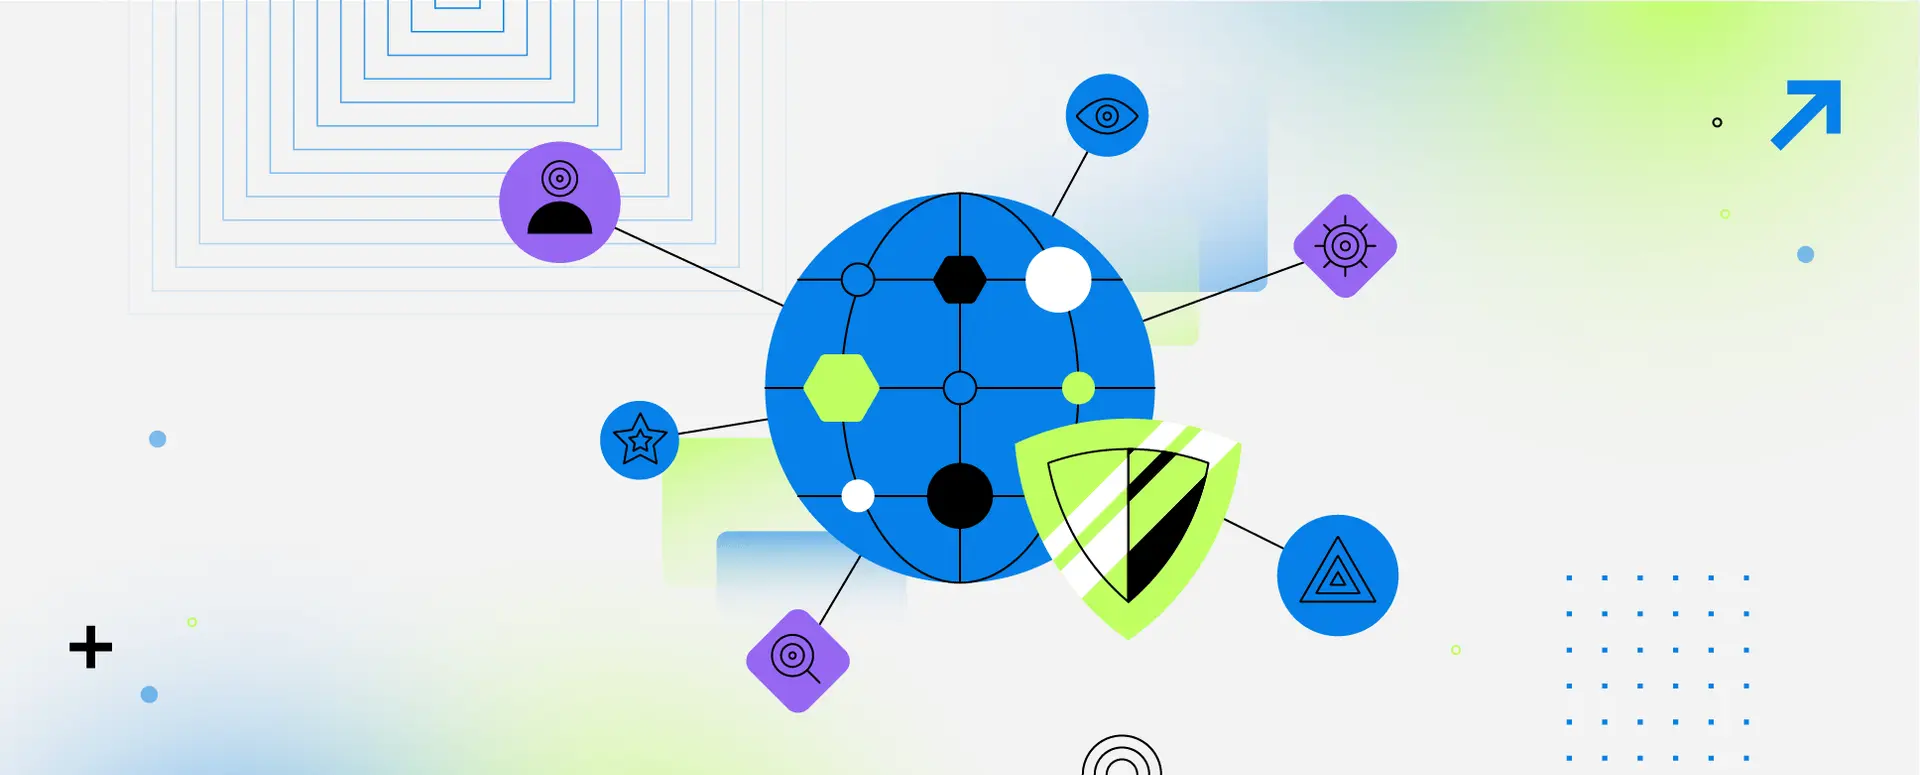
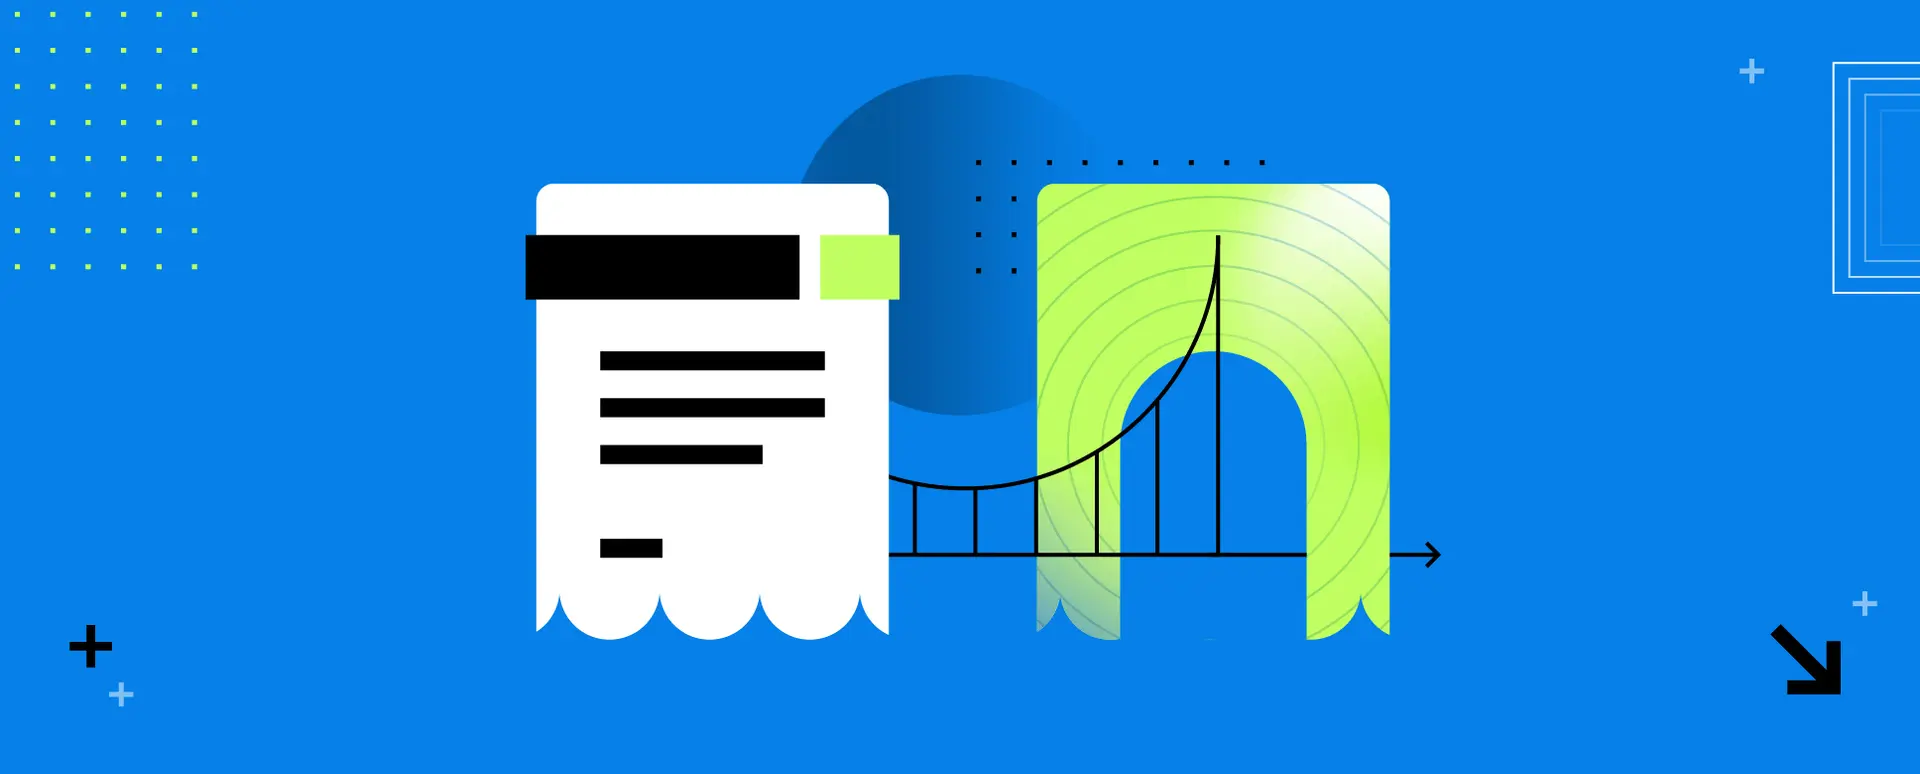

In [ ]:
# Create a list of strings by concatenating the 'markdown' field in each 'data' list
result_strings = []
for item in results:
    # Join all 'markdown' text into a single string for each dictionary
    combined_text = " ".join([entry['markdown'] for entry in item['data']])
    result_strings.append(combined_text)

# Output the result
print(result_strings)

After crawling is done, we setup an LLM to figure out whether or not this product (or vendor) passes our requirements.

For example, we want our tool to have support for Google Drive, is SOC 2 compliant, and HIPAA compliant.

First, let's setup Groq to be able to use Llama 3.2-11B model to judge whether or not the vendor passes our criteria.

In [ ]:
pip install groq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
from groq import Groq
import getpass

GROQ_API_KEY=getpass.getpass("Groq API Key: ")

client = Groq(api_key=GROQ_API_KEY)

Groq API Key: ··········


In [ ]:
system_message = f"""
You're a helpful assistance who looks at information
about a software vendor and determines whether or not
they are a good fit. You also give explanations to why
you think they are or are not.

The criteria are that the vendor needs to pass the following
1. a SaaS product
2. SOC 2 as main focus and not one of their offerings
3. Testimonials from F500 companies
"""

In [ ]:
def get_response(query: str, context: str):
  completion = client.chat.completions.create(
      model="llama-3.2-11b-text-preview",
      messages=[
          {
              "role": "system",
              "content": system_message
          },
          {
              "role": "user",
              "content": context
          },
          {
              "role": "user",
              "content": query
          }
      ],
      temperature=0,
      max_tokens=1470,
      top_p=1,
      stream=False,
      stop=None,
  )

  return completion.choices[0].message.content

In [ ]:
MAX_TOKENS = 7000 # claude: 128K

for i, result_string in enumerate(result_strings):
    # Truncate the result_string if it's longer than MAX_TOKENS
    if len(result_string) > MAX_TOKENS:
        result_string = result_string[:MAX_TOKENS]

    response = get_response("Does this vendor meet the requirements?", result_string)
    print(f"Vendor: {vendors[i]}")
    print(response)
    print("-" * 50)

Vendor: https://secureframe.com/
Based on the information provided, Secureframe appears to meet the requirements:

1. **SaaS product**: Secureframe is a cloud-based platform that offers a range of features and tools for security, risk, and compliance management. It is a Software as a Service (SaaS) product, which meets this requirement.

2. **SOC 2 as main focus and not one of their offerings**: Secureframe's main focus is on security, risk, and compliance management, which includes SOC 2 compliance. However, it's not explicitly stated that SOC 2 is their main focus. But, they do offer SOC 2 compliance as one of their features. This might not fully meet the requirement, but it's close.

3. **Testimonials from F500 companies**: Secureframe has a list of customers that includes several well-known companies, including F500 companies like Nasdaq, Lyra, and others. This meets the requirement.

However, considering the third requirement, I would say that Secureframe meets the requirement but